<a href="https://colab.research.google.com/github/Ale-Cie/Titanic_Disaster_ML/blob/main/Titanic_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Titanic Disaster ML Notebook

In this notebook we will go through the dataset available in the Kaggle competiton which can be found under this <a href="https://www.kaggle.com/competitions/titanic/">link</a>.

If we begin by reading the competition's overview we quickly learn that we're faced with a binary classification task. By following the Scikit-Learn model selection map we get a few suggestions already - `LinearSVC()`, `KNeighborsClassifier()`,`DecisionTreeClassifier()` and if all else fails the `RandomForestClassifier()`. From previous experiences I know that `LogisticRegression()` works pretty good with binary classification as well.

We will roughly follow these steps:
 - Defining the problem (Which Kaggle kindly did for us)
 - Exploring the data
 - Create initial model(s) and tuning the hyperparameters
 - Evaluating the model(s) 
 - Experimenting untill satisfied 

Let's start by importing all the tools we will need.

In [25]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm  import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split

from warnings import filterwarnings

In [2]:
filterwarnings("ignore")

## Data exploration and preparation

Here is a quick recap of all the features:

 - Survived: Survival	0 = No, 1 = Yes
 - Pclass: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
 - Sex: Sex
 - Age: Age in years
 - SibSp: # of siblings / spouses aboard the Titanic
 - Parch: # of parents / children aboard the Titanic
 - Ticket: Ticket number	
 - Fare: Passenger fare
 - Cabin: Cabin number	
 - Embarked:	Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
# Let's load in the training dataset and explore it a bit
try:
  df = pd.read_csv("/content/drive/MyDrive/Titanic ML Comp/train.csv")
except:
  df = pd.DataFrame(os.system("cmd /c _ kaggle competitions download -c titanic"))

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
np.sum(df.isna())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.shape

(891, 12)

### Data preparation

Looking at the shape of this dataset and the amount of missing "Cabin" data, we probably should remove this column from the DataFrame - even with any manipulation it would not be representative of the actual values.

Passengers with missing "Embarked" values can be easily dropped, and the "Name" column I think can be dropped too, since how the person was named doesn't really influence their survavibility... I can always be proved wrong though.

"Age" column is quite perplexing. One one hand there aren't that many missing values and removing them won't affect the scale of the dataset that much. We could always try making a mean estimate.

Oh and for the "Embarked" and "Sex" columns we will have to make the numerical values out of the text given.

In [6]:
# We will define a function now, because the exact same changes will have to be made on the test data later on
def data_manipulator(df):
  # Let's start by dropping the entire "Cabin" and "Name" columns and then we will drop all rows with missing values
  df.drop(["Cabin", "Name"], axis=1, inplace= True)

  # We have to change the index values in the DataFrame after removing rows, since it causes some silly bugs
  # While we're at it let's make a quick loop to turn the alphabetical values in the "Embarked" and "Sex" into numericals
  # Values will go as follows: for Embarked - C=0, Q=1, S=2
  # For Sex - male=0, female=1
  for idx in df.index:
    embarked = df["Embarked"][idx]
    sex = df["Sex"][idx]
    if embarked == "C":
      embarked = 0
    elif embarked == "Q":
      embarked = 1
    elif embarked =="S":
      embarked = 2
    else:
      pass
    if sex == "male":
      sex = 0
    else:
      sex = 1

    df["Embarked"][idx] = embarked
    df["Sex"][idx] = sex

  # Here I will attempt to turn "object" type tickets into int64 tickets by cutting off the letters
  #I doubt it's a good practice but for now it should do
  ticket_list = []
  for ticket in df["Ticket"]:
    new_ticket = ""
    for char in ticket:
      if char.isnumeric():
        new_ticket += char
      else:
        continue
    if new_ticket == "":
      new_ticket = None
    ticket_list.append(new_ticket)

  df["Ticket"] = ticket_list

  df.dropna(inplace= True)
  df = df.astype({"Embarked": "int64", "Sex": "int64", "Ticket": "int64"})
  return df

df = data_manipulator(df)


In [7]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,0,22.0,1,0,521171,7.2500,2
1,2,1,1,1,38.0,1,0,17599,71.2833,0
2,3,1,3,1,26.0,0,0,23101282,7.9250,2
3,4,1,1,1,35.0,1,0,113803,53.1000,2
4,5,0,3,0,35.0,0,0,373450,8.0500,2


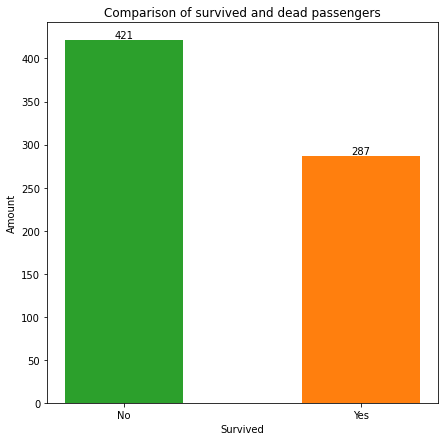

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.bar(x=["No", "Yes"], height=df["Survived"].value_counts(), color=["tab:green", "tab:orange"], width=0.5)
plt.title("Comparison of survived and dead passengers")
plt.xlabel("Survived")
plt.ylabel("Amount")
for container in ax.containers:
  ax.bar_label(container);



In [9]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket           int64
Fare           float64
Embarked         int64
dtype: object

Now that we have numerical values in all columns we can start dividing data into X, y, train and validation sets and start experimenting with different models

### X & y sets creation

Although we are using `train_test_split` we have to remember that we will be dividing our DataFrame into 'train' set and 'validation' set, since the actual test set is given to us by Kaggle. We will be scoring our models on the validation set and then making real predictions on the test set.

In [10]:
np.random.seed(31)
# Let's start by creating the X and y sets

X = df.drop(["Survived"], axis=1)
y = df["Survived"]

# Now it's time for creating train and test sets

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.25)

## Modelling

Now that we have our data separated and ready to be used it's time to start the modelling process. I will begin with creating a dictionary of all the imported models

### Instantiating and scoring the default models

We will start by creating default models and checking their accuracy. Next we will go through different means of evaluation and see whitch model performs best and which should be grid searched etc.

In [11]:
def_models = {
    "LinearSVC": LinearSVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [12]:
for name, model in def_models.items():
  print(f"Fitting {name} model...")
  model.fit(X_train, y_train)
  print(f"{name}'s accuracy score is %.3f \n" % (model.score(X_validation, y_validation)*100))


Fitting LinearSVC model...
LinearSVC's accuracy score is 44.444 

Fitting KNeighborsClassifier model...
KNeighborsClassifier's accuracy score is 59.510 

Fitting LogisticRegression model...
LogisticRegression's accuracy score is 58.380 

Fitting DecisionTreeClassifier model...
DecisionTreeClassifier's accuracy score is 75.895 

Fitting RandomForestClassifier model...
RandomForestClassifier's accuracy score is 80.414 



The results are in and... They're not very good at the first glance. We can see that the best estimations were done by the two most complex of the tested models - `DecisionTreeClassifier()` and `RandomForestClassifier()`. We'll follow along with those.

The reasons to consider are:
- Bad data engineering (that would be on me)
- Bad choice of the estimators (unlikely since these were advised by scikit-learn documentation)
- Not enough data (possible, but there's nothing we can really do)
- Just need to tune the hyperparameters

### Tuning hyperparameters

We will start the next step by creating a rather extensive parameter grid which will be used first in `RandomizedSearchCV()`. Afterwards we will (probably) trim it down a bit and put it into `GridSearchCV()`.

#### `RandomizedSearchCV()` hyperparameter tuning

We will begin with `RandomizedSearchCV()` so we need to create two separate parameter grids.

In [30]:
dt_param_grid = {
    "splitter": ["best", "random"],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "min_samples_leaf": range(2, 30, 3),
    "min_samples_split": range(2, 50, 4),
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

In [35]:
randsearch_dt = RandomizedSearchCV(
    estimator= DecisionTreeClassifier(),
    param_distributions= dt_param_grid,
    n_iter= 100,
    cv= 5,
    verbose= True
)
np.random.seed(31)
randsearch_dt.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': range(2, 30, 3),
                                        'min_samples_split': range(2, 50, 4),
                                        'splitter': ['best', 'random']},
                   verbose=True)

In [38]:
print(f"RandomizedSearchCV DecisionTreeClassifier model score equals: %.3f " % (randsearch_dt.score(X_validation, y_validation)*100))

RandomizedSearchCV DecisionTreeClassifier model score equals: 75.895 


In [39]:
for key, value in randsearch_dt.best_params_.items():
  print(f"{key}: {value}")

splitter: best
min_samples_split: 46
min_samples_leaf: 14
max_features: sqrt
max_depth: 60
criterion: gini


In [41]:
rf_param_grid = {
  "bootstrap": [True, False],
  "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
  "max_features": ['auto', 'sqrt'],
  "min_samples_leaf": range(2, 30, 3),
  "min_samples_split": range(2, 50, 4),
  "n_estimators": [64, 128, 200, 256, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
  "warm_start": [True, False]
}

In [14]:
randsearch_rf = RandomizedSearchCV(
    estimator= RandomForestClassifier(),
    param_distributions= rf_param_grid,
    n_iter= 100,
    cv= 5,
    verbose= True
)
np.random.seed(31)
randsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(2, 30, 3),
                                        'min_samples_split': range(2, 50, 4),
                                        'n_estimators': [64, 128, 200, 256, 400,
                                                         600, 800, 1000, 1200,
                                                         1400, 1600, 1800,
                                                         2000],
                                        'warm_start': [True, False]},
                   verbose=True)

In [32]:
print(f"RandomizedSearchCV RandomForesClassifier model score equals: %.3f " % (randsearch_rf.score(X_validation, y_validation)*100))

RandomizedSearchCV RandomForesClassifier model score equals: 79.849 


In [16]:
for key, value in randsearch_rf.best_params_.items():
  print(f"{key}: {value}")

warm_start: True
n_estimators: 1200
min_samples_split: 6
min_samples_leaf: 5
max_features: sqrt
max_depth: None
bootstrap: True


By the looks of it this result is fairly consistent with the default model, so I have high hopes we are not troubled by over-fitting. Next step is trying to find an even better model with `GridSearchCV()` but since `RandomizedSearchCV()` took us somewhere between 10-15 minutes we have to trim some values from our parameter grid. I will do it with the help of current best parameters.

#### `GridSearchCV()` hyperparameter tuning

Let's start by remembering what parameter grids we used and comparing them to the `best_params_`:

##### `DecisionTreeClassifier`

In [44]:
for key, value in dt_param_grid.items():
  print(f"{key}: {value}")

splitter: ['best', 'random']
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_leaf: range(2, 30, 3)
min_samples_split: range(2, 50, 4)
max_features: ['sqrt', 'log2']
criterion: ['gini', 'entropy']


In [45]:
for key, value in randsearch_dt.best_params_.items():
  print(f"{key}: {value}")

splitter: best
min_samples_split: 46
min_samples_leaf: 14
max_features: sqrt
max_depth: 60
criterion: gini


In [50]:
dt_param_grid_2 = {
    "splitter": ["best", "random"],
    "max_depth": [10, 30, 60, 100, None],
    "min_samples_leaf": [5, 8, 14, 23, 29],
    "min_samples_split": [10, 22, 34, 46],
    "max_features": ["sqrt"],
    "criterion": ["gini", "entropy"]
}

In [51]:
gridsearch_dt = GridSearchCV(
    estimator= DecisionTreeClassifier(),
    param_grid= dt_param_grid_2,
    cv= 5,
    verbose= True
)

np.random.seed(31)
gridsearch_dt.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30, 60, 100, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 8, 14, 23, 29],
                         'min_samples_split': [10, 22, 34, 46],
                         'splitter': ['best', 'random']},
             verbose=True)

In [53]:
print(f"GridSearchCV DecisionTreeClassifier model score equals: %.3f " % (gridsearch_dt.score(X_validation, y_validation)*100))

GridSearchCV DecisionTreeClassifier model score equals: 77.778 


In [54]:
gridsearch_dt.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 14,
 'min_samples_split': 46,
 'splitter': 'best'}

##### `RandomForestClassifier()`

In [42]:
for key, value in rf_param_grid.items():
  print(f"{key}: {value}")

bootstrap: [True, False]
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
max_features: ['auto', 'sqrt']
min_samples_leaf: range(2, 30, 3)
min_samples_split: range(2, 50, 4)
n_estimators: [64, 128, 200, 256, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
warm_start: [True, False]


In [18]:
for key, value in randsearch_rf.best_params_.items():
  print(f"{key}: {value}")

warm_start: True
n_estimators: 1200
min_samples_split: 6
min_samples_leaf: 5
max_features: sqrt
max_depth: None
bootstrap: True


In [46]:
rf_param_grid_2 = {
    "bootstrap": [True],
    "max_depth": [None, 10, 40, 80],
    "max_features": ["sqrt"],
    "min_samples_leaf": [2, 5, 14, 20],
    "min_samples_split": [2, 6, 18, 42],
    "n_estimators": [128, 256, 800, 1200],
    "warm_start": [True]    
}

In [20]:
gridsearch_rf = GridSearchCV(
    estimator= RandomForestClassifier(),
    param_grid= rf_param_grid_2,
    cv= 5,
    verbose= True
)
np.random.seed(31)
gridsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [None, 10, 40, 80],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5, 14, 20],
                         'min_samples_split': [2, 6, 18, 42],
                         'n_estimators': [128, 256, 800, 1200],
                         'warm_start': [True]},
             verbose=True)

In [52]:
print(f"GridSearchCV RandomForestClassifier model score equals: %.3f " % (gridsearch_rf.score(X_validation, y_validation)*100))

GridSearchCV RandomForestClassifier model score equals: 80.603 


In [22]:
for key, value in gridsearch_rf.best_params_.items():
  print(f"{key}: {value}")

bootstrap: True
max_depth: None
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 1200
warm_start: True


## Evaluation

Next step is evaluating the models. We will do it via these measures:
- ROC Curve and AUC score
- Confusion matrix
- Classification report
- Accuracy
- Precision
- Recall
- F1-score

First three of them can be done on the `best_estimator` models found in our searches. 

The last four however will be done differently - we will have to create new instances of these models, with hyperparameters found through `RandomizedSearchCV()` and `GridSearchCV()`. Next, we will define a function to test the metrics using the `cross_val_score` and we will check their performance, and in the end choose, fit and use the best one of them to make predictions on the test set provided by Kaggle.

### ROC Curve an AUC score


#### `DecisionTreeClassifier()`

In [58]:
y_randsearch_dt_preds = randsearch_dt.best_estimator_.predict_proba(X_validation)[::,1]
y_gridsearch_dt_preds = gridsearch_dt.best_estimator_.predict_proba(X_validation)[::,1]

evaluated_dt_models = {
    "RandomizedSearchCV model": randsearch_dt.best_estimator_,
    "GridSearchCV model": gridsearch_dt.best_estimator_
}


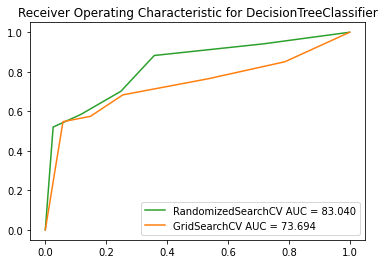

In [59]:
# Plotting the ROC Curve

randsearch_dt_fpr, randsearch_dt_tpr, randsearch_dt_threshold = roc_curve(y_validation, y_randsearch_dt_preds)
gridsearch_dt_fpr, gridsearch_dt_tpr, gridsearch_dt_threshold = roc_curve(y_validation, y_gridsearch_dt_preds)

randsearch_dt_auc = auc(randsearch_dt_fpr, randsearch_dt_tpr)
gridsearch_dt_auc = auc(gridsearch_dt_fpr, gridsearch_dt_tpr)

fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic for DecisionTreeClassifier")
plt.plot(randsearch_dt_fpr, randsearch_dt_tpr, label="RandomizedSearchCV AUC = %0.3f"%(randsearch_dt_auc*100), color="tab:green")
plt.plot(gridsearch_dt_fpr, gridsearch_dt_tpr, label="GridSearchCV AUC = %0.3f"%(gridsearch_dt_auc*100), color="tab:orange")
plt.legend(loc="lower right");


#### `RandomForrestClassifier()`

In [60]:
y_randsearch_rf_preds = randsearch_rf.best_estimator_.predict_proba(X_validation)[::,1]
y_gridsearch_rf_preds = gridsearch_rf.best_estimator_.predict_proba(X_validation)[::,1]

evaluated_rf_models = {
    "RandomizedSearchCV model": randsearch_rf.best_estimator_,
    "GridSearchCV model": gridsearch_rf.best_estimator_
}


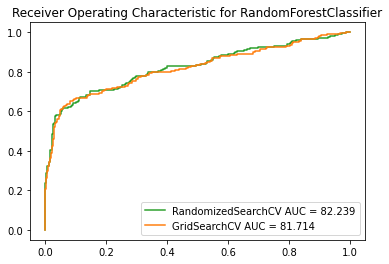

In [61]:
# Plotting the ROC Curve

randsearch_rf_fpr, randsearch_rf_tpr, randsearch_rf_threshold = roc_curve(y_validation, y_randsearch_rf_preds)
gridsearch_rf_fpr, gridsearch_rf_tpr, gridsearch_rf_threshold = roc_curve(y_validation, y_gridsearch_rf_preds)

randsearch_rf_auc = auc(randsearch_rf_fpr, randsearch_rf_tpr)
gridsearch_rf_auc = auc(gridsearch_rf_fpr, gridsearch_rf_tpr)

fig, ax = plt.subplots()
plt.title("Receiver Operating Characteristic for RandomForestClassifier")
plt.plot(randsearch_rf_fpr, randsearch_rf_tpr, label="RandomizedSearchCV AUC = %0.3f"%(randsearch_rf_auc*100), color="tab:green")
plt.plot(gridsearch_rf_fpr, gridsearch_rf_tpr, label="GridSearchCV AUC = %0.3f"%(gridsearch_rf_auc*100), color="tab:orange")
plt.legend(loc="lower right");


### Confusion Matrix

#### `DecisionTreeClassifier()`

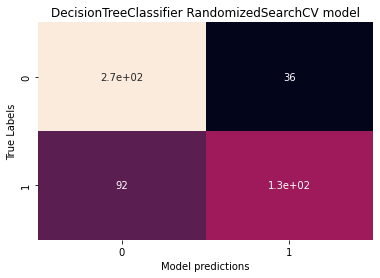

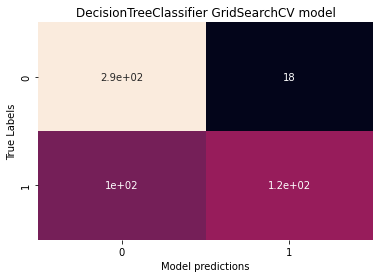

In [64]:
def plot_conf_mat(y_test, y_preds, name):
  fig, ax = plt.subplots()
  ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False)
  plt.title("DecisionTreeClassifier "+ name)
  plt.xlabel("Model predictions")
  plt.ylabel("True Labels")

for name, model in evaluated_dt_models.items():
  plot_conf_mat(y_validation, model.predict(X_validation), name)

#### `RandomForestClassifier()`

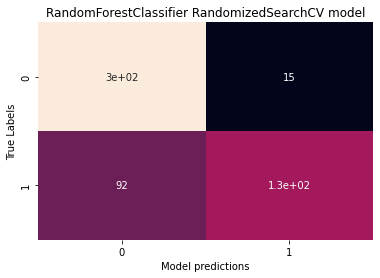

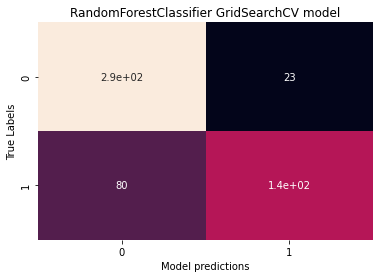

In [63]:
def plot_conf_mat(y_test, y_preds, name):
  fig, ax = plt.subplots()
  ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False)
  plt.title("RandomForestClassifier "+ name)
  plt.xlabel("Model predictions")
  plt.ylabel("True Labels")

for name, model in evaluated_rf_models.items():
  plot_conf_mat(y_validation, model.predict(X_validation), name)

###Classification Report

#### `DecisionTreeClassifier()`

In [69]:
for name, model in evaluated_dt_models.items():
  print(f"Classification report for DecisionTreeClassifier() {name}:\n\n{classification_report(y_validation, model.predict(X_validation))}")

Classification report for DecisionTreeClassifier() RandomizedSearchCV model:

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       310
           1       0.78      0.58      0.67       221

    accuracy                           0.76       531
   macro avg       0.77      0.73      0.74       531
weighted avg       0.76      0.76      0.75       531

Classification report for DecisionTreeClassifier() GridSearchCV model:

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       310
           1       0.87      0.55      0.67       221

    accuracy                           0.78       531
   macro avg       0.81      0.74      0.75       531
weighted avg       0.80      0.78      0.77       531



#### `RandomForestClasiifier()`

In [68]:
for name, model in evaluated_rf_models.items():
  print(f"Classification report for RandomForestClassifier() {name}:\n\n{classification_report(y_validation, model.predict(X_validation))}")

Classification report for RandomForestClassifier() RandomizedSearchCV model:

              precision    recall  f1-score   support

           0       0.76      0.95      0.85       310
           1       0.90      0.58      0.71       221

    accuracy                           0.80       531
   macro avg       0.83      0.77      0.78       531
weighted avg       0.82      0.80      0.79       531

Classification report for RandomForestClassifier() GridSearchCV model:

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       310
           1       0.86      0.64      0.73       221

    accuracy                           0.81       531
   macro avg       0.82      0.78      0.79       531
weighted avg       0.81      0.81      0.80       531



### Cross-Validated Metrics